In [1]:
pip install -q 'gwosc==0.7.1'

In [2]:
pip install -q pycbc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 2.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 36.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 9.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━

In [3]:
pip install -q 'gwpy==3.0.12'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 23.9 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


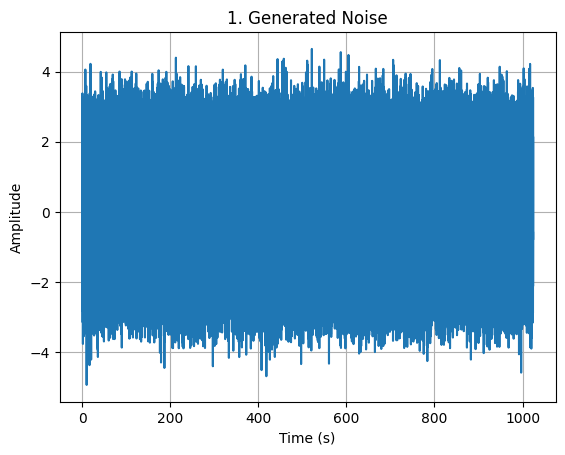

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from pycbc.psd import interpolate, aLIGOZeroDetHighPower
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.filter import matched_filter

# === Parameters ===
sample_rate = 1024  # Hz
data_length = 1024  # seconds
delta_t = 1.0 / sample_rate

# === Generate Gaussian Noise ===
data = np.random.normal(0, 1, sample_rate * data_length)
data = TimeSeries(data, delta_t=delta_t)

plt.plot(data.sample_times, data, label='Gaussian Noise')
plt.title("1. Generated Noise")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()

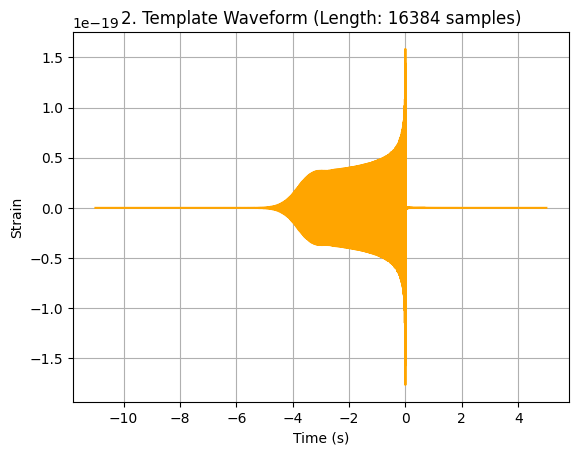

In [5]:
# === Generate GW Template Signal ===
hp, _ = get_td_waveform(
    approximant='IMRPhenomD',
    mass1=10, mass2=10,
    delta_t=delta_t,
    f_lower=25
)

plt.plot(hp.sample_times, hp, label='Template Waveform', color='orange')
plt.title(f"2. Template Waveform (Length: {len(hp)} samples)")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid()

/tmp/ipython-input-6-1149962433.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  norm_factor = np.sqrt(abs(float(np.vdot(hp, hp))))  # Safe normalization


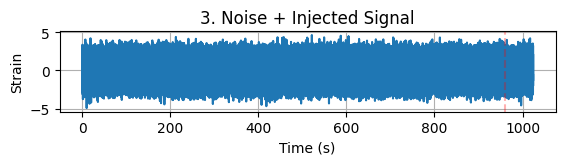

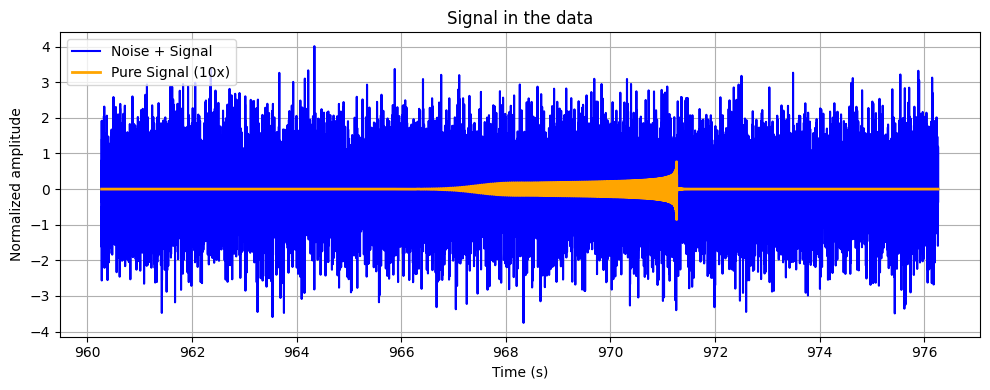

In [6]:
# === Normalize the waveform ===
norm_factor = np.sqrt(abs(float(np.vdot(hp, hp))))  # Safe normalization
hp = hp / norm_factor

# === Inject signal into data at random location ===
injection_start = np.random.randint(0, len(data) - len(hp))
hp.start_time = data.start_time + injection_start * delta_t

# Create a copy of the data before injection
data_before = data.copy()
data[injection_start:injection_start+len(hp)] += 10 * hp

# Plot 1: Full data with injection point marked
plt.subplot(4, 1, 3)
plt.plot(data.sample_times, data, label='Data with Injected Signal')
plt.axvline(injection_start * delta_t, color='red', alpha=0.3, linestyle='--')
plt.title("3. Noise + Injected Signal")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.grid()

# Plot 2: Zoomed-in view of the injected signal
plt.figure(figsize=(10, 4))
plt.title("Signal in the data")
# Plot the segment containing the injected signal
signal_segment = data[injection_start:injection_start+len(hp)]
time_segment = np.arange(injection_start, injection_start+len(hp)) * delta_t
plt.plot(time_segment, signal_segment, 'b', label='Noise + Signal')
# Plot the pure injected signal (10x amplified)
plt.plot(time_segment, 10 * hp, 'orange', linewidth=2, label='Pure Signal (10x)')
plt.xlabel('Time (s)')
plt.ylabel('Normalized amplitude')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

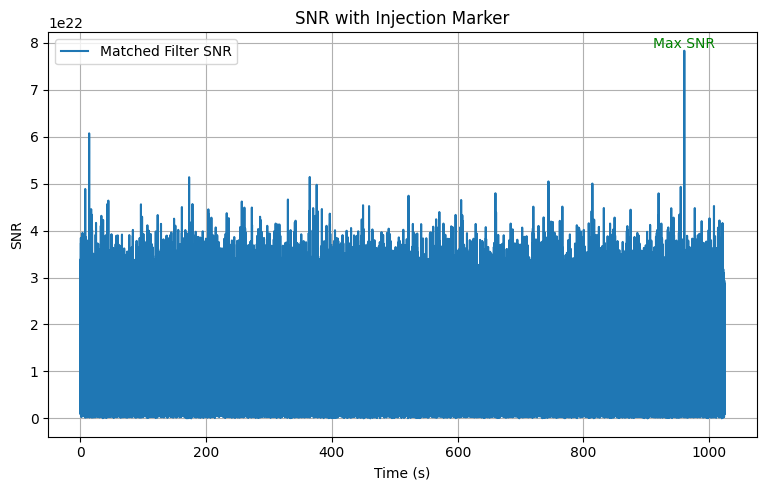

In [13]:
# === Estimate PSD ===
psd = aLIGOZeroDetHighPower(len(data), delta_f=1.0/data_length, low_freq_cutoff=20)

# === Zero-pad the template to match data length ===
hp_padded = TimeSeries(np.zeros(len(data)), delta_t=delta_t)
hp_padded[:len(hp)] = hp

# === Apply matched filter ===
snr = matched_filter(hp_padded, data, psd=psd, low_frequency_cutoff=25)

# === Create figure with two subplots ===
plt.figure(figsize=(15, 5))

# First subplot: With red line showing injection time
plt.subplot(1, 2, 1)
plt.plot(snr.sample_times, abs(snr), label="Matched Filter SNR")
plt.text(max_snr_time, max_snr_value + 0.5, f'Max SNR',
         color='green', ha='center', va='bottom', fontsize=10)
#plt.axvline(data.start_time + injection_start * delta_t, color='red', linestyle='--', label='Injected Signal')
plt.title("SNR with Injection Marker")
plt.xlabel("Time (s)")
plt.ylabel("SNR")
plt.legend()
plt.grid()



plt.tight_layout()
plt.show()